# Elo rating system overview

1. [High-level concepts of Elo Rating Sytem](#high-level-concepts-of-elo-rating-sytem)
2. [Key concepts and parameters](#the-key-concepts-and-parameters)

## High-level concepts of Elo Rating Sytem


### What is Elo rating system?
The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess.

### Why using Elo rating system?
> The Elo rating system is a method for calculating the relative skill levels of players, which has been widely adopted in competitive games and sports. The difference in the ratings between two players serves as a predictor of the outcome of a match. The Elo rating system works well for our case because we have multiple models and we run pairwise battles between them.
> -- <cite>https://lmsys.org/blog/2023-05-03-arena/</cite>

### Formulas
- #### Expected Score(A有多少百分比赢B)
If player A has a rating of $R_A$, and player B a rating of $R_B$, the exact formula(using the logistic curve with base 10) for the probability of player A winner is:
$$
E_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}}
$$

- #### Updating Rating
The ratings of players can be linearly updated after each battle. Suppose player A (with Rating) was expected to score points $E_A$ but actually scored points $S_A$. The formula for updating that player's rating is:
$$
R'_A = R_A + K \cdot (S_A - E_A)
$$

### Statistical Validation of Elo rating system
- Perform backtesting by applying the rating system to historical data and comparing predicted outcomes with actual results.
- Adjust the parameters until the predictions align closely with the actual outcomes.

Example:
> 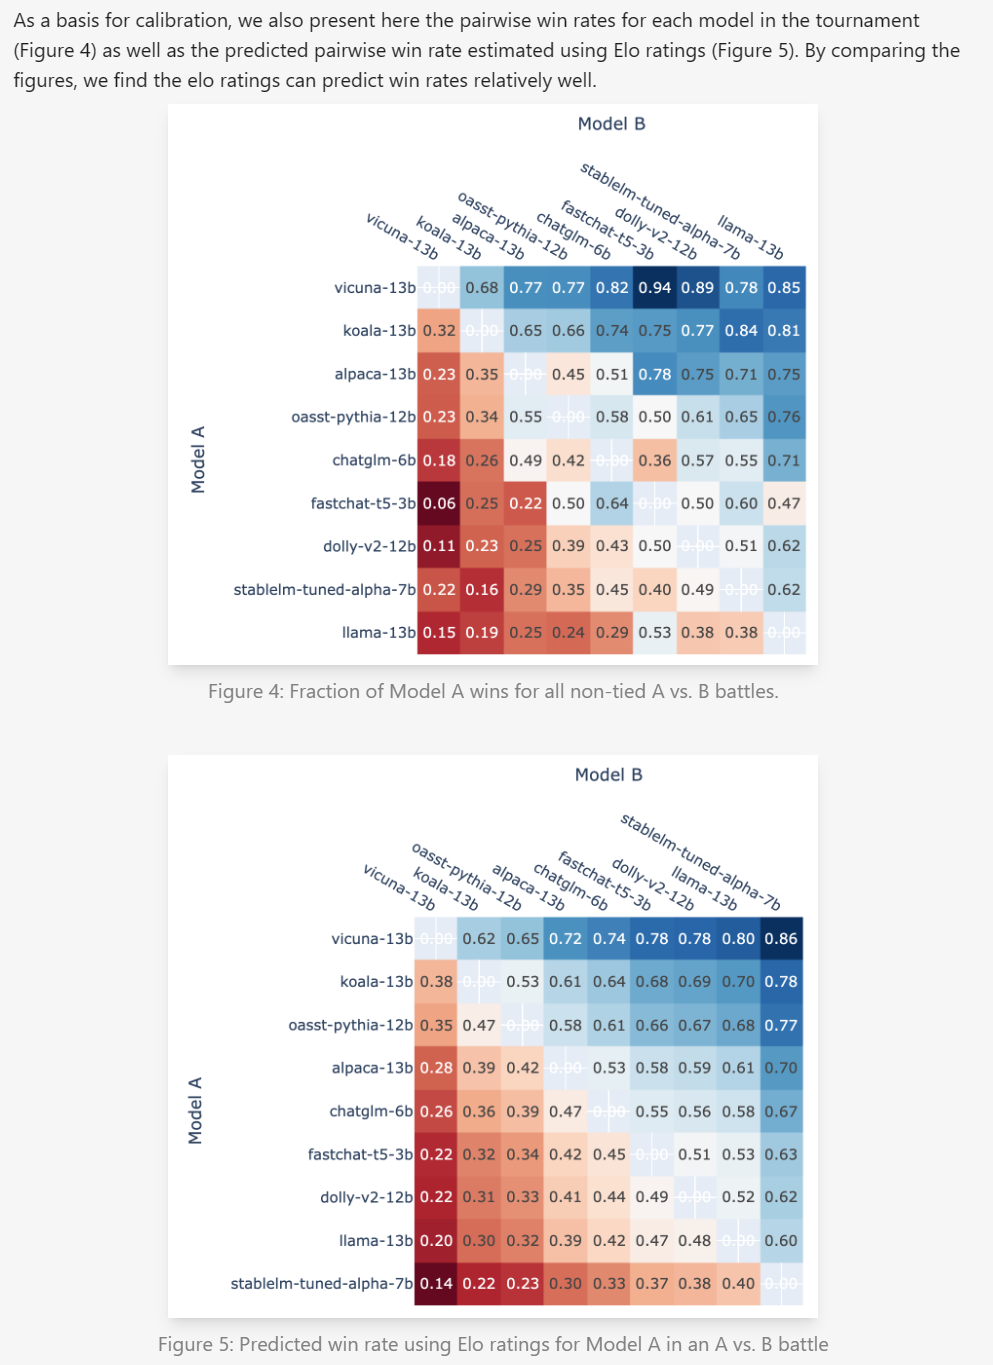
> -- <cite>https://lmsys.org/blog/2023-05-03-arena/</cite>

## The key concepts and parameters
1. **Rating(Rating number越大越厉害)**: Each player has a numerical rating that represents their skill level. New players are assigned a provisional rating, which gets adjusted over time as they play more games.
2. **Expected Score**: Before a game, the Elo system calculates the expected score for each player, which is the estimated probability of each player winning based on their current ratings. The expected score is calculated using the formula:
    $$
    E_A = \frac{1}{1 + 10^{\frac{R_B - R_A}{400}}}
    $$

    Here, $E_A$ is the expected score for player A, $R_A$ is the rating of player A, and $R_B$ is the rating of player B.

3. **K-Factor**： The K-factor is a constant that determines how much a player's rating will change based on the game outcome. A higher K-factor allows ratings to change more rapidly, while a lower K-factor results in slower changes but gain in stability. 

4. **Rating Update**: After a game, the players' ratings are updated based on the actual score and the expected score. The formula for updating a player's rating is:
    
    $$
    R' = R + K \cdot (S - E)
    $$
    
    Here, R’ is the new rating, R is the current rating, K is the K-factor, S is the actual score (1 for a win, 0.5 for a draw, and 0 for a loss), and E is the expected score.

5. **Zero-sum**: The Elo rating system, originally developed for chess but used in various other games and sports, is designed to be a zero-sum system. This means that the total number of points in the system remains constant; points gained by the winner are equal to the points lost by the loser. The fundamental reasons for this design are fairness, simplicity, and the system's purpose of providing a relative measure of players' skills.
6. **Win Rate**: The win rate can be inferred from these expected scores. For example, an expected score of 0.75 for player A against player B suggests that player A is expected to win about 75% of the time against player B.

#### What's the numerical range of expected score?
In the Elo ranking system, the expected score (E) represents the estimated probability that a player (or team) will win a game. It is calculated based on the difference in ratings between the two players (or teams) involved.

The numerical range of the expected score is from 0 to 1:

- **0**: Represents a 0% probability of winning. This would occur in the theoretical scenario where there's an infinitely large rating difference between the players, with the lower-rated player having virtually no chance of winning.
- **1**: Represents a 100% probability of winning. Similarly, this would occur in the theoretical scenario where there's an infinitely large rating difference in favor of the higher-rated player.

Most commonly, however, expected scores fall somewhere between these two extremes, indicating that both players have some chance of winning. For example:

- An expected score of 0.5 means that the player has an estimated 50% chance of winning, typically occurring when both players have equal ratings.
- An expected score of 0.75 means that the player has an estimated 75% chance of winning, indicating that they are the stronger player according to their Elo rating.

## Code Example
We first use the online linear update algorithm to compute Elo ratings. We choose a small K-factor of 4 to make the Elo ratings more stable and less biased towards recent games.

However, even with a small K-factor, we still found this online update algoirhtm not stable enough, so we did not use this version directly for our leaderboard, but will use a bootstrap version of this later.

code source: https://colab.research.google.com/drive/1RAWb22-PFNI-X1gPVzc927SGUdfr6nsR?usp=sharing#scrollTo=QLGc6DwxyvQc

In [14]:
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np

battled_pairs = r'..\results\log_battle_arena_gpt4_as_judger.csv'
df = pd.read_csv(battled_pairs)
columns_to_inclusive = ['model_a', 'model_b', 'winner']
data = df[columns_to_inclusive]

data_no_nan = data[data['winner'].isna()==False]
data_no_ties = data[data['winner'].str.contains('tie', na=False) == False]
data_ties_only = data[data['winner'].str.contains('tie', na=False) == True]

data_no_nan

,model_a,model_b,winner
0,chatglm-6b,koala-13b,model_b
1,oasst-pythia-12b,alpaca-13b,model_a
2,koala-13b,oasst-pythia-12b,model_a
3,vicuna-13b,oasst-pythia-12b,model_a
4,vicuna-13b,koala-13b,model_a
...,...,...,...
495,vicuna-13b,koala-13b,model_a
496,vicuna-13b,alpaca-13b,tie
497,vicuna-13b,oasst-pythia-12b,model_a
498,chatglm-6b,koala-13b,model_b


In [15]:
def compute_elo(battles, K=4, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, winner in battles[['model_a', 'model_b', 'winner']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if winner == "model_a":
            sa = 1
        elif winner == "model_b":
            sa = 0
        elif winner == "tie" or winner == "tie(all bad)":
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {winner}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    return rating

In [55]:
def preety_print_elo_ratings(ratings):
    df = pd.DataFrame([
        [n, elo_ratings[n]] for n in elo_ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

elo_ratings = compute_elo(data_no_nan)
# preety_print_elo_ratings(elo_ratings)

Actual Winrate vs Predict Winrate

In [17]:
def compute_pairwise_win_fraction(battles):
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_a"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_b"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles,
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) /
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig = px.imshow(row_beats_col, color_continuous_scale='RdBu',
                    text_auto=".2f", title=title)
    fig.update_layout(xaxis_title=" Model B: Loser",
                  yaxis_title="Model A: Winner",
                  xaxis_side="top", height=600, width=600,
                  title_y=0.07, title_x=0.5)
    fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Fraction of A Wins: %{z}<extra></extra>")

    return fig

[nan,
 0.6551724137931034,
 0.7857142857142857,
 0.7058823529411765,
 0.8392857142857143,
 0.9047619047619048,
 0.8275862068965517,
 0.78125,
 0.28448275862068967,
 nan,
 0.8461538461538461,
 0.7142857142857143,
 0.8285714285714286,
 0.9,
 0.8,
 0.7647058823529411,
 0.21428571428571427,
 0.15384615384615385,
 nan,
 0.8333333333333334,
 0.5,
 0.6666666666666666,
 1.0,
 1.0,
 0.29411764705882354,
 0.2857142857142857,
 0.0,
 nan,
 0.25,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.14285714285714285,
 0.14285714285714285,
 0.5,
 0.75,
 nan,
 0.0,
 0.6,
 0.6,
 0.047619047619047616,
 0.1,
 0.3333333333333333,
 0.3333333333333333,
 1.0,
 nan,
 0.5,
 nan,
 0.06896551724137931,
 0.2,
 0.0,
 0.3333333333333333,
 0.4,
 0.5,
 nan,
 1.0,
 0.15625,
 0.23529411764705882,
 0.0,
 0.3333333333333333,
 0.4,
 nan,
 0.0,
 nan]

In [11]:
fig = visualize_pairwise_win_fraction(data_no_ties,
      title = "Fraction of Model A Wins for All Non-tied A vs. B Battles")
fig

In [12]:
def predict_win_rate(elo_ratings, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(elo_ratings.keys()))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((elo_ratings[b] - elo_ratings[a]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {
        a: [wins[a][b] if a != b else np.NAN for b in names]
        for a in names
    }

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

In [13]:
win_rate = predict_win_rate(elo_ratings)
ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
fig = px.imshow(win_rate.loc[ordered_models, ordered_models],
                color_continuous_scale='RdBu', text_auto=".2f",
                title="Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
fig.update_layout(xaxis_title="Model B",
                  yaxis_title="Model A",
                  xaxis_side="top", height=600, width=600,
                  title_y=0.07, title_x=0.5)
fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Win Rate: %{z}<extra></extra>")
fig

In [76]:
actual_winrate = compute_pairwise_win_fraction(data_no_ties)
actual_winrate

# Iterating over the lower left triangle(excluding the diagonal)
Y_true = []
for i in range(len(actual_winrate)):
    for j in range(i):  # j goes from 0 to i
        # Accessing the element at row i, column j
        value = df.iloc[i, j]
        Y_true.append(value)
       
Y_pred = [] 
for i in range(len(win_rate)):
    for j in range(i):  # j goes from 0 to i
        # Accessing the element at row i, column j
        value = df.iloc[i, j]
        Y_pred.append(value)


Y_true = np.array(actual_winrate.values.flatten().tolist())
Y_pred = np.array(win_rate.values.flatten().tolist())

from sklearn.metrics import mean_squared_error 
  
# Calculation of Mean Squared Error (MSE) 

import numpy as np

def mse_mae_with_nan_handling(true, pred):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    mse = ((true[mask] - pred[mask]) ** 2).mean()
    mae = (np.abs(true[mask] - pred[mask])).mean()
    return mse, mae

mse_mae_with_nan_handling(Y_true,Y_pred)

(0.14524706360777032, -0.009018655354862258)